In [1]:
import numpy as np
import pandas as pd

import geopy.distance

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

import networkx as nx
from pyvis.network import Network

from utils.PreProcessor import PreProcessor

In [2]:
# %time preprocessor = PreProcessor(sample_num = 1, preprocess_all_raw_data = True)

In [3]:
%time preprocessor = PreProcessor(sample_num = 1, preprocess_all_raw_data = False)

**************************************
Loading PreProcessed Datasets
Loaded AirRouteDatasets
Loaded Domestic Passenger Data
Loaded Indian Railways Data
Loaded Socio-Economic Data
Loaded Monument Visitors Data
**************************************
CPU times: user 29.7 ms, sys: 9.23 ms, total: 39 ms
Wall time: 38.3 ms


## Air Route Dataset

In [4]:
preprocessor.city_mapping.head()

,City,AirRouteData_AirportCode,DomesticPassengerTraffic_City,EconomicData_District,StationCodeData_District,Airport_City_Coords,EducationData_District,PopulationAreaHousehold_District,LatestPopulation_City,PopulationHistory_District
0,Ahmedabad,AMD,AHMEDABAD,NaN,Ahmadabad,"23.073702560470423, 72.62711816841471",AHMADABAD,Ahmadabad,Ahmedabad,ahmadabad
1,Bengaluru,BLR,BENGALURU,{BANGALORE URBAN + BANGALORE RURAL},Bangalore Urban,"13.199253589160458, 77.70610499457639",{BANGALORE + BANGALORE RURAL},{Bangalore + Bangalore Rural},Bengaluru,{bangalore + bangalore rural}
2,Mumbai,BOM,MUMBAI,MUMBAI,Greater Bombay,"19.099282513860523, 72.87502185672862",{MUMBAI + MUMBAI SUBURBAN},{Mumbai Suburban + Mumbai},{Mumbai + Navi Mumbai},{mumbai suburban + mumbai}
3,Pune,PNQ,PUNE,PUNE,Pune,"18.57956672029852, 73.90948542603986",PUNE,Pune,Pune,pune
4,Chennai,MAA,CHENNAI,CHENNAI,Chennai,"12.994341981037747, 80.17159635853399",CHENNAI,Chennai,Chennai,chennai


In [5]:
preprocessor.all_network_data.head()

,From,To,Distance,Time,Cheapest Price,Aircraft Type,Number of Flights
0,AMD,IXC,583,105,59,Narrow Body,5.0
1,AMD,DED,598,110,103,Narrow Body,1.0
2,AMD,DEL,469,95,48,Narrow Body,24.0
3,AMD,JAI,326,80,53,Narrow Body,1.0
4,AMD,LKO,575,105,69,Narrow Body,4.0


In [6]:
preprocessor.all_airport_data.head()

,City/Town,Name,Airport Traffic Level
0,Ahmedabad,AMD,1
1,Bhuj,BHJ,3
2,Jaisalmer,JSA,3
3,Jodhpur,JDH,2
4,Jammu,IXJ,3


In [7]:
preprocessor.network_data.head()

,From,FromHub,To
0,COK,0,BLR
1,COK,0,DEL
2,MAA,0,BLR
3,MAA,0,HYD
4,MAA,0,GAU


## Domestic Passenger Traffic Dataset

In [8]:
preprocessor.total_domestic_data.head()

,Route,FROM,TO,PASSENGERS,FREIGHT,MAIL,DAYS
0,AGARTALA-AHMEDABAD,AGARTALA,AHMEDABAD,3038.0,52.357,0.0,365
1,AGARTALA-AIZAWL,AGARTALA,AIZAWL,5780.0,0.087,0.0,365
2,AGARTALA-BENGALURU,AGARTALA,BENGALURU,44195.0,367.947,0.0,365
3,AGARTALA-BHUBANESWAR,AGARTALA,BHUBANESWAR,18.0,0.000,0.0,61
4,AGARTALA-CHENNAI,AGARTALA,CHENNAI,12767.0,0.000,0.0,304


## Railways Dataset

In [9]:
preprocessor.all_station_districts_data.head()

,StationCode,District,State
0,BDHL,Jaipur,Rajasthan
1,KHH,Bareilly,Uttar Pradesh
2,SRKN,Hanumangarh,Rajasthan
3,BKKA,Hanumangarh,Rajasthan
4,NHR,Hanumangarh,Rajasthan


In [10]:
preprocessor.city_to_city_train_dict['Greater Bombay']['Pune']

[{'duration': 184.38666666671634,
  'train_num': '11017',
  'third_ac': 1,
  'chair_car': 0,
  'first_class': 0,
  'sleeper': 1,
  'second_ac': 1,
  'type': 'Exp',
  'first_ac': 0},
 {'duration': 209.31081081181765,
  'train_num': '11019',
  'third_ac': 1,
  'chair_car': 0,
  'first_class': 0,
  'sleeper': 1,
  'second_ac': 1,
  'type': 'Exp',
  'first_ac': 0},
 {'duration': 202.9632432423532,
  'train_num': '11023',
  'third_ac': 1,
  'chair_car': 0,
  'first_class': 0,
  'sleeper': 1,
  'second_ac': 1,
  'type': 'Exp',
  'first_ac': 0},
 {'duration': 185.25396825373173,
  'train_num': '11025',
  'third_ac': 0,
  'chair_car': 1,
  'first_class': 0,
  'sleeper': 0,
  'second_ac': 0,
  'type': 'Exp',
  'first_ac': 0},
 {'duration': 200.63416988402605,
  'train_num': '11027',
  'third_ac': 1,
  'chair_car': 0,
  'first_class': 0,
  'sleeper': 1,
  'second_ac': 1,
  'type': 'Mail',
  'first_ac': 0},
 {'duration': 199.4989189170301,
  'train_num': '11029',
  'third_ac': 0,
  'chair_car': 1

## Preparing Dataset

In [11]:
tier_1_2_cities = preprocessor.city_mapping['City'].values
print(len(tier_1_2_cities))
print(tier_1_2_cities)

22
['Ahmedabad' 'Bengaluru' 'Mumbai' 'Pune' 'Chennai' 'Hyderabad' 'Kolkata'
 'Delhi' 'Visakhapatnam' 'Guwahati' 'Patna' 'Raipur' 'Gurugram' 'Shimla'
 'Jamshedpur' 'Thiruvananthapuram' 'Bhopal' 'Bhubaneswar' 'Amritsar'
 'Jaipur' 'Lucknow' 'Dehradun']


In [12]:
tier_1_2_cities_airports = preprocessor.city_mapping['AirRouteData_AirportCode'].dropna().values
print(tier_1_2_cities_airports)

['AMD' 'BLR' 'BOM' 'PNQ' 'MAA' 'HYD' 'CCU' 'DEL' 'VTZ' 'GAU' 'PAT' 'RPR'
 'TRV' 'BHO' 'BBI' 'ATQ' 'JAI' 'LKO' 'DED']


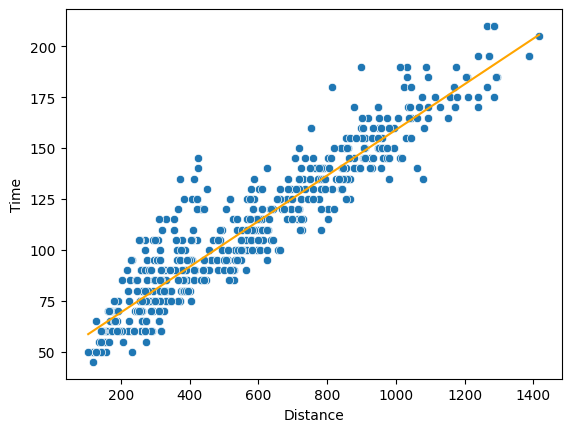

In [13]:
distance_time_curve_fit = np.polyfit(preprocessor.all_network_data['Distance'].values, preprocessor.all_network_data['Time'].values, 1)
sns.scatterplot(data = preprocessor.all_network_data, x = 'Distance', y = 'Time')
sns.lineplot(x = preprocessor.all_network_data['Distance'].values, y = preprocessor.all_network_data['Distance'].values * distance_time_curve_fit[0] + distance_time_curve_fit[1], color = 'orange')
plt.show()

In [14]:
FORECAST_YEAR = 2033
PRESENT_YEAR = 2023

In [15]:
def get_route_passenger_traffic_data(cities):
    city_to_city_mapping = dict(zip(preprocessor.city_mapping['DomesticPassengerTraffic_City'], preprocessor.city_mapping['City']))
    route_traffic = []
    for idx, row in preprocessor.total_domestic_data.iterrows():
        if((row['FROM'] in city_to_city_mapping) and (row['TO'] in city_to_city_mapping)):
            route_traffic.append([city_to_city_mapping[row['FROM']], city_to_city_mapping[row['TO']], row['PASSENGERS']])
    route_traffic_df = pd.DataFrame(route_traffic, columns = ['From', 'To', 'Passengers_Target'])
    return route_traffic_df

route_traffic_df = get_route_passenger_traffic_data(tier_1_2_cities)
route_traffic_df['Year'] = pd.Series([PRESENT_YEAR] * route_traffic_df.shape[0])
route_traffic_df['Connecting'] = pd.Series([''] * route_traffic_df.shape[0])
route_traffic_df.head()

,From,To,Passengers_Target,Year,Connecting
0,Ahmedabad,Amritsar,13033.0,2023,
1,Ahmedabad,Bengaluru,405751.0,2023,
2,Ahmedabad,Bhopal,20514.0,2023,
3,Ahmedabad,Bhubaneswar,16866.0,2023,
4,Ahmedabad,Chennai,139900.0,2023,


### Railway Routes Info

In [16]:
def get_railways_info_features(raw_route_traffic_df):
    route_traffic_df = raw_route_traffic_df.copy()
    railway_info = []
    city_to_district_mapping = dict(zip(preprocessor.city_mapping['City'].values, preprocessor.city_mapping['StationCodeData_District'].values))
    for idx, row in route_traffic_df.iterrows():
        from_district = city_to_district_mapping[row['From']]
        to_district = city_to_district_mapping[row['To']]
        if(from_district not in preprocessor.city_to_city_train_dict):
            railway_info.append([row['From'], row['To']] + [0, np.nan, np.nan])
        else:
            if(to_district not in preprocessor.city_to_city_train_dict[from_district]):
                railway_info.append([row['From'], row['To']] + [0, np.nan, np.nan])
            else:
                route_railway_info = preprocessor.city_to_city_train_dict[from_district][to_district]
                num_trains = len(route_railway_info)
                avg_duration = np.nanmean([x['duration'] for x in route_railway_info])
                third_ac = np.nansum([x['third_ac'] for x in route_railway_info])
                chair_car = np.nansum([x['chair_car'] for x in route_railway_info])
                first_class = np.nansum([x['first_class'] for x in route_railway_info])
                sleeper = np.nansum([x['sleeper'] for x in route_railway_info])
                second_ac = np.nansum([x['second_ac'] for x in route_railway_info])
                first_ac = np.nansum([x['first_ac'] for x in route_railway_info])
                # Based on https://en.wikipedia.org/wiki/Indian_Railways_coaching_stock & https://www.quora.com/What-is-the-capacity-of-normal-Indian-passenger-train
                #   first_ac -> 20 (1x20)
                #   second_ac -> 100 (2x50)
                #   third_ax -> 180 (3x60)
                #   chair_car -> 150 (75x2)
                #   sleeper -> 840 (12x70)
                #   first_class -> 20 (1x20)
                capacity = (
                    first_ac * 20 +
                    second_ac * 100 +
                    third_ac * 180 +
                    chair_car * 150 +
                    sleeper * 840 +
                    first_class * 20
                )
                # Forecasting growth of railways
                #    -> Based on https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiQp_S3qNP9AhXIwTgGHYuaB5EQFnoECA8QAQ&url=https%3A%2F%2Findianrailways.gov.in%2Frailwayboard%2Fuploads%2Fdirectorate%2Fstat_econ%2FAnnual-Reports-2020-2021%2FAnnual-Report-English.pdf&usg=AOvVaw2YMsSpEfqTOjBD13N-ZsJl,
                #    -> On average, over the past decade, number of passenger coaches increased by ~1000 per year while total running track increased by ~1000 km per year
                #    -> On average, growth rate in railway connectivity & passenger capacity was ~2% per year
                num_trains = num_trains + num_trains * (2 / 100) * (row['Year'] - PRESENT_YEAR)
                capacity = capacity + capacity * (2 / 100) * (row['Year'] - PRESENT_YEAR)
                railway_info.append([row['From'], row['To'], row['Year']] + [num_trains, avg_duration, capacity])
    railway_info_df = pd.DataFrame(railway_info, columns = ['From', 'To', 'Year', 'NumTrains_Railways', 'Duration_Railways', 'Capacity_Railways'])
    route_traffic_df = pd.merge(route_traffic_df, railway_info_df, on = ['From', 'To', 'Year'], how = 'left')
    return route_traffic_df

route_traffic_df = get_railways_info_features(route_traffic_df)
route_traffic_df.head()

,From,To,Passengers_Target,Year,Connecting,NumTrains_Railways,Duration_Railways,Capacity_Railways
0,Ahmedabad,Amritsar,13033.0,2023,,NaN,NaN,NaN
1,Ahmedabad,Bengaluru,405751.0,2023,,3.0,2044.650000,3360.0
2,Ahmedabad,Bhopal,20514.0,2023,,2.0,914.930556,2240.0
3,Ahmedabad,Bhubaneswar,16866.0,2023,,NaN,NaN,NaN
4,Ahmedabad,Chennai,139900.0,2023,,NaN,NaN,NaN


### Route Flight Duration

In [17]:
OVERLAY_TIME = 120
def get_route_timing_features(raw_route_traffic_df):
    
    def get_timing(from_airport, to_airport):
        route_timing_data = preprocessor.all_network_data[(preprocessor.all_network_data['From'] == from_airport) & (preprocessor.all_network_data['To'] == to_airport)]
        if(route_timing_data.shape[0] == 0):
            from_airport_coords = airport_to_coords_mapping[from_airport]
            from_airport_coords_lat = float(from_airport_coords.split(',')[0])
            from_airport_coords_lon = float(from_airport_coords.split(',')[1])
            from_airport_coords = (from_airport_coords_lat, from_airport_coords_lon)
            to_airport_coords = airport_to_coords_mapping[to_airport]
            to_airport_coords_lat = float(to_airport_coords.split(',')[0])
            to_airport_coords_lon = float(to_airport_coords.split(',')[1])
            to_airport_coords = (to_airport_coords_lat, to_airport_coords_lon)
            route_distance = geopy.distance.geodesic(from_airport_coords, to_airport_coords).miles
            route_timing = route_distance * distance_time_curve_fit[0] + distance_time_curve_fit[1]
        else:
            assert(route_timing_data['Time'].nunique() == 1)
            route_timing = route_timing_data['Time'].mean()
        return route_timing
    
    route_traffic_df = raw_route_traffic_df.copy()
    route_timings = []
    airport_to_coords_mapping = dict(zip(preprocessor.city_mapping['AirRouteData_AirportCode'].values, preprocessor.city_mapping['Airport_City_Coords'].values))
    city_to_airport_mapping = dict(zip(preprocessor.city_mapping['City'].values, preprocessor.city_mapping['AirRouteData_AirportCode'].values))
    for idx, row in route_traffic_df.iterrows():
        from_airport = city_to_airport_mapping[row['From']]
        to_airport = city_to_airport_mapping[row['To']]
        connecting = row['Connecting']
        if(connecting == ''):
            route_timing = get_timing(from_airport, to_airport)
        else:
            connecting_airport = city_to_airport_mapping[connecting]
            route_timing = get_timing(from_airport, connecting_airport) + get_timing(connecting_airport, to_airport) + OVERLAY_TIME
        route_timings.append(route_timing)
    route_traffic_df['Duration_AirRoute'] = pd.Series(route_timings)
    return route_traffic_df

route_traffic_df = get_route_timing_features(route_traffic_df)
route_traffic_df.head()

,From,To,Passengers_Target,Year,Connecting,NumTrains_Railways,Duration_Railways,Capacity_Railways,Duration_AirRoute
0,Ahmedabad,Amritsar,13033.0,2023,,NaN,NaN,NaN,115.147624
1,Ahmedabad,Bengaluru,405751.0,2023,,3.0,2044.650000,3360.0,130.000000
2,Ahmedabad,Bhopal,20514.0,2023,,2.0,914.930556,2240.0,85.000000
3,Ahmedabad,Bhubaneswar,16866.0,2023,,NaN,NaN,NaN,125.000000
4,Ahmedabad,Chennai,139900.0,2023,,NaN,NaN,NaN,140.000000


### PCA values

In [18]:
pca_vals_df = pd.read_csv('./Analysis_Outputs/Present_Features/data_pca_X.csv')
pca_cols = ['City_' + x for x in pca_vals_df.columns if x != 'City']
pca_vals_df.columns = pca_cols + ['City']
pca_vals_df['Year'] = pd.Series([PRESENT_YEAR] * pca_vals_df.shape[0])
pca_vals_df.head()

,City_economic_pca1,City_economic_pca2,City_tourism_pca1,City_tourism_pca2,City_education_pca1,City_education_pca2,City_population_pca1,City_population_pca2,City,Year
0,0.000000,0.0,-0.238236,-0.238172,1.395963,-0.387739,1.692132,0.272176,Ahmedabad,2023
1,1.418418,0.0,0.497358,-0.100107,8.068454,-0.931443,3.787218,1.291372,Bengaluru,2023
2,3.651202,0.0,2.110816,-0.857722,9.510857,0.099851,5.651798,-2.315697,Mumbai,2023
3,1.405861,0.0,0.363223,-0.263905,4.859875,-1.292795,2.911178,3.283686,Pune,2023
4,-0.349614,0.0,0.988575,4.315512,0.342898,0.505098,0.616446,-2.718586,Chennai,2023


In [19]:
pca_vals_forecasted_df = {}
for year in range(PRESENT_YEAR + 1, FORECAST_YEAR + 1):
    pca_vals_forecasted_year_df = pd.read_csv(f"./Analysis_Outputs/Forecasted_Features/{year}.csv")
    pca_vals_forecasted_year_df.columns = ['City_' + x if x != 'City' else x for x in pca_vals_forecasted_year_df.columns]
    pca_vals_forecasted_year_df['Year'] = pd.Series([year] * pca_vals_forecasted_year_df.shape[0])
    pca_vals_forecasted_df[year] = pca_vals_forecasted_year_df

In [20]:
total_pca_vals_df = pca_vals_df
for year in pca_vals_forecasted_df:
    total_pca_vals_df = pd.concat([total_pca_vals_df, pca_vals_forecasted_df[year]], axis = 0)
total_pca_vals_df.head()

,City_economic_pca1,City_economic_pca2,City_tourism_pca1,City_tourism_pca2,City_education_pca1,City_education_pca2,City_population_pca1,City_population_pca2,City,Year
0,0.000000,0.0,-0.238236,-0.238172,1.395963,-0.387739,1.692132,0.272176,Ahmedabad,2023
1,1.418418,0.0,0.497358,-0.100107,8.068454,-0.931443,3.787218,1.291372,Bengaluru,2023
2,3.651202,0.0,2.110816,-0.857722,9.510857,0.099851,5.651798,-2.315697,Mumbai,2023
3,1.405861,0.0,0.363223,-0.263905,4.859875,-1.292795,2.911178,3.283686,Pune,2023
4,-0.349614,0.0,0.988575,4.315512,0.342898,0.505098,0.616446,-2.718586,Chennai,2023


In [21]:
def get_pca_vals_features(raw_route_traffic_df):
    route_traffic_df = raw_route_traffic_df.copy()
    route_traffic_df = pd.merge(route_traffic_df, total_pca_vals_df, left_on = ['From', 'Year'], right_on = ['City', 'Year'], how = 'left')
    route_traffic_df = pd.merge(route_traffic_df, total_pca_vals_df, left_on = ['To', 'Year'], right_on = ['City', 'Year'], how = 'left', suffixes = ('_pca_vals_FROM', '_pca_vals_TO'))
    
    route_traffic_df = route_traffic_df.drop(['City_pca_vals_TO', 'City_pca_vals_FROM'], axis = 1)
    for col in pca_cols:
        route_traffic_df[f'{col}_avg_PCA'] = (route_traffic_df[f'{col}_pca_vals_FROM'] + route_traffic_df[f'{col}_pca_vals_TO']) / 2
        route_traffic_df[f'{col}_diff_PCA'] = (route_traffic_df[f'{col}_pca_vals_FROM'] - route_traffic_df[f'{col}_pca_vals_TO'])
        route_traffic_df = route_traffic_df.drop([f'{col}_pca_vals_FROM', f'{col}_pca_vals_TO', f'{col}_pca_vals_FROM', f'{col}_pca_vals_TO'], axis = 1)
    
    return route_traffic_df

route_traffic_df = get_pca_vals_features(route_traffic_df)
print(route_traffic_df.columns)
route_traffic_df.head()

Index(['From', 'To', 'Passengers_Target', 'Year', 'Connecting',
       'NumTrains_Railways', 'Duration_Railways', 'Capacity_Railways',
       'Duration_AirRoute', 'City_economic_pca1_avg_PCA',
       'City_economic_pca1_diff_PCA', 'City_economic_pca2_avg_PCA',
       'City_economic_pca2_diff_PCA', 'City_tourism_pca1_avg_PCA',
       'City_tourism_pca1_diff_PCA', 'City_tourism_pca2_avg_PCA',
       'City_tourism_pca2_diff_PCA', 'City_education_pca1_avg_PCA',
       'City_education_pca1_diff_PCA', 'City_education_pca2_avg_PCA',
       'City_education_pca2_diff_PCA', 'City_population_pca1_avg_PCA',
       'City_population_pca1_diff_PCA', 'City_population_pca2_avg_PCA',
       'City_population_pca2_diff_PCA'],
      dtype='object')


,From,To,Passengers_Target,Year,Connecting,NumTrains_Railways,Duration_Railways,Capacity_Railways,Duration_AirRoute,City_economic_pca1_avg_PCA,...,City_tourism_pca2_avg_PCA,City_tourism_pca2_diff_PCA,City_education_pca1_avg_PCA,City_education_pca1_diff_PCA,City_education_pca2_avg_PCA,City_education_pca2_diff_PCA,City_population_pca1_avg_PCA,City_population_pca1_diff_PCA,City_population_pca2_avg_PCA,City_population_pca2_diff_PCA
0,Ahmedabad,Amritsar,13033.0,2023,,NaN,NaN,NaN,115.147624,-0.239450,...,-0.129219,-0.217906,-1.413060,5.618046,-0.295450,-0.184577,0.088556,3.207153,0.041363,0.461625
1,Ahmedabad,Bengaluru,405751.0,2023,,3.0,2044.650000,3360.0,130.000000,0.709209,...,-0.169140,-0.138065,4.732209,-6.672491,-0.659591,0.543704,2.739675,-2.095086,0.781774,-1.019196
2,Ahmedabad,Bhopal,20514.0,2023,,2.0,914.930556,2240.0,85.000000,-0.292688,...,-0.607825,0.739306,-1.224958,5.241843,-0.056124,-0.663229,0.082121,3.220022,-0.314135,1.172622
3,Ahmedabad,Bhubaneswar,16866.0,2023,,NaN,NaN,NaN,125.000000,-0.257725,...,-0.255426,0.034509,-1.308932,5.409790,-0.168100,-0.439278,-0.083709,3.551682,0.329168,-0.113986
4,Ahmedabad,Chennai,139900.0,2023,,NaN,NaN,NaN,140.000000,-0.174807,...,2.038670,-4.553684,0.869430,1.053066,0.058680,-0.892836,1.154289,1.075686,-1.223205,2.990761


In [22]:
y_features = [x for x in route_traffic_df.columns if x.endswith('_Target')]
X_features = [x for x in route_traffic_df.columns if (x.endswith('_PCA')) or (x.endswith('_AirRoute')) or (x.endswith('_Railways'))]

In [23]:
# Trimming data for model training - Removing routes having no target variable
# Standardizing data
valid_route_traffic_df = route_traffic_df.copy()
print("Number of invalid rows:", pd.isnull(valid_route_traffic_df[X_features + y_features]).sum().sum())
cols_standardization_vals = {}
for col_idx, col in enumerate(valid_route_traffic_df.columns):
    if((col in X_features) or (col in y_features)):
        if(col in y_features):
            to_drop_idx = pd.isnull(valid_route_traffic_df[col])
            to_drop_idx = to_drop_idx[to_drop_idx == True].index
            valid_route_traffic_df = valid_route_traffic_df.drop(to_drop_idx, axis = 0)
        elif(col in X_features):
            col_mean = np.nanmean(valid_route_traffic_df[col].values)
            valid_route_traffic_df[col] = valid_route_traffic_df[col].fillna(col_mean)
        col_mean = valid_route_traffic_df[col].mean()
        col_std = valid_route_traffic_df[col].std()
        valid_route_traffic_df[col] = (valid_route_traffic_df[col] - col_mean) / (col_std + 1e-20)
        cols_standardization_vals[col] = {'mean': col_mean, 'std': col_std}
print("Number of invalid rows after cleaning:", pd.isnull(valid_route_traffic_df[X_features + y_features]).sum().sum())
print(valid_route_traffic_df.shape)
valid_route_traffic_df.head()

Number of invalid rows: 195
Number of invalid rows after cleaning: 0
(286, 25)


,From,To,Passengers_Target,Year,Connecting,NumTrains_Railways,Duration_Railways,Capacity_Railways,Duration_AirRoute,City_economic_pca1_avg_PCA,...,City_tourism_pca2_avg_PCA,City_tourism_pca2_diff_PCA,City_education_pca1_avg_PCA,City_education_pca1_diff_PCA,City_education_pca2_avg_PCA,City_education_pca2_diff_PCA,City_population_pca1_avg_PCA,City_population_pca1_diff_PCA,City_population_pca2_avg_PCA,City_population_pca2_diff_PCA
0,Ahmedabad,Amritsar,-0.584459,2023,,0.000000,0.000000,0.000000,-0.178305,-0.574454,...,-0.245446,-0.131504,-0.668368,0.654319,-0.559887,-0.153046,-0.203476,0.993361,0.210835,0.163457
1,Ahmedabad,Bengaluru,0.458776,2023,,-0.662666,0.813668,-0.640298,0.227822,0.723420,...,-0.296987,-0.083320,1.027732,-0.777127,-1.210112,0.450823,1.645983,-0.648918,0.791441,-0.360888
2,Ahmedabad,Bhopal,-0.564586,2023,,-0.783002,-0.970170,-0.784816,-1.002669,-0.647289,...,-0.863366,0.446163,-0.616451,0.610503,-0.132536,-0.549929,-0.207965,0.997348,-0.067936,0.415215
3,Ahmedabad,Bhubaneswar,-0.574277,2023,,0.000000,0.000000,0.000000,0.091101,-0.599457,...,-0.408391,0.020826,-0.639628,0.630064,-0.332485,-0.364236,-0.323650,1.100074,0.436523,-0.040361
4,Ahmedabad,Chennai,-0.247444,2023,,0.000000,0.000000,0.000000,0.501265,-0.486015,...,2.553474,-2.748096,-0.038398,0.122648,0.072461,-0.740312,0.539995,0.333176,-0.780799,1.059002


In [24]:
data_X = valid_route_traffic_df[X_features].values
data_y = valid_route_traffic_df[y_features].values[:, 0]
data_cities = [(x[0], x[1]) for x in valid_route_traffic_df[['From', 'To']].values]
print(data_X.shape, data_y.shape)

(286, 20) (286,)


Coefficients:  [0.2105033541014683, 0.07391918589991728, 0.17098303653532682, 0.03240359153120467, 0.41192364058389264, 0.00249763130691335, 0, 0, 0.5839363112153578, 0.003363653667320173, 0.019317889269748124, 0.000734439263557287, 0.7392912607971127, 0.0019389044182057653, 0.2227844312777151, 0.0006123176786400014, 0.2661885300914039, 0.004327373552026853, 0.40126871638419, 0.0022359574113633082]


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


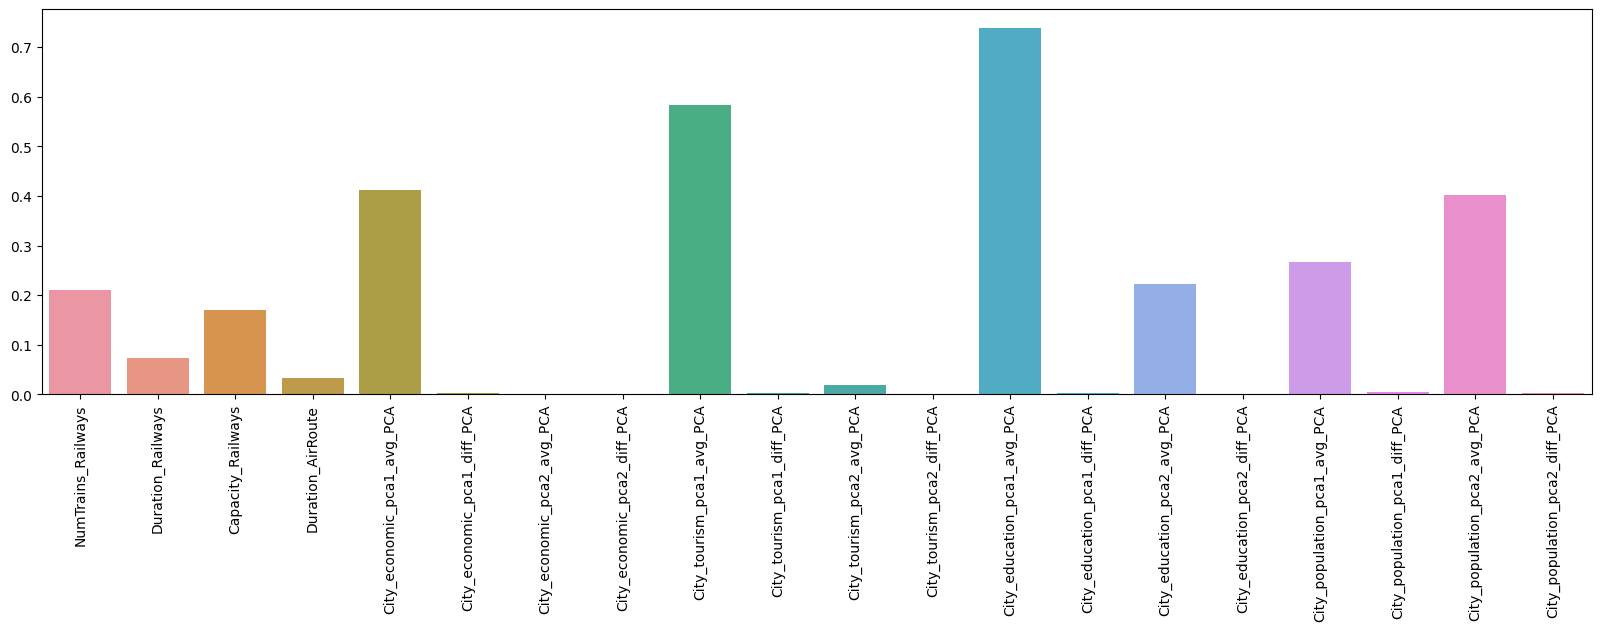

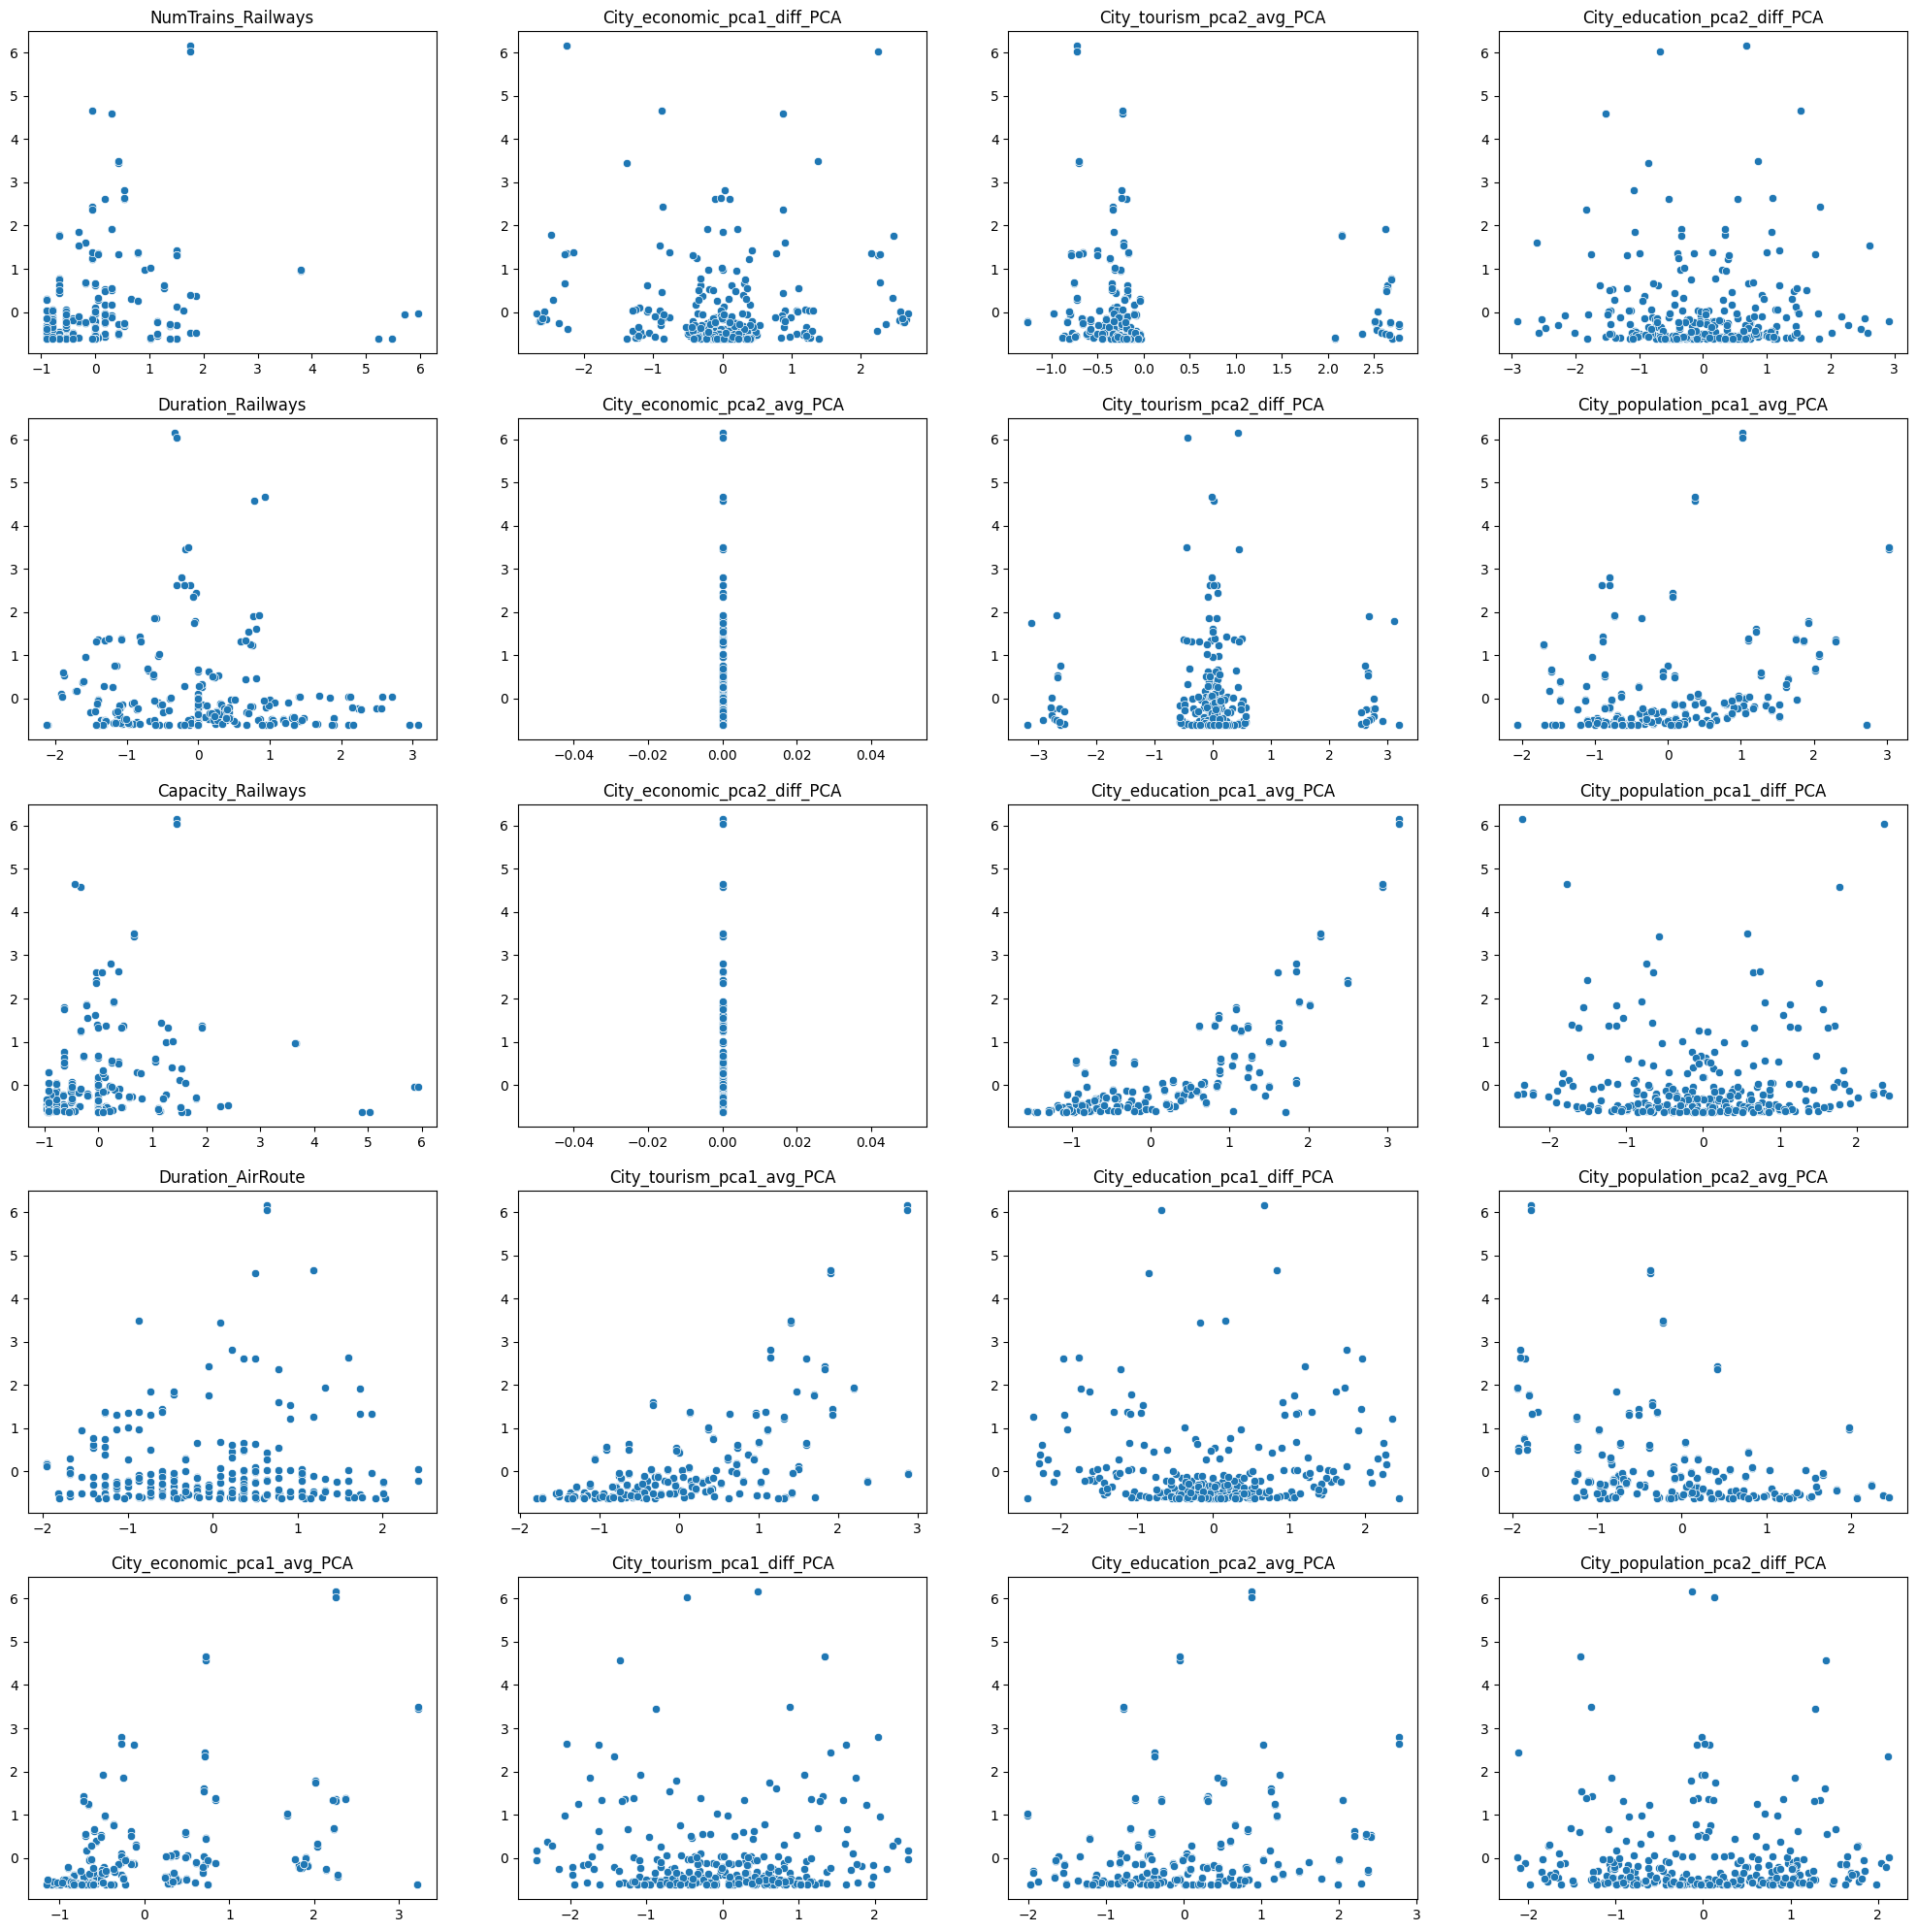

In [25]:
corr_coefs = []
for idx in range(len(X_features)):
    corr = np.abs(np.corrcoef(data_X[:, idx], data_y)[0, 1])
    if(pd.isnull(corr)):
        corr = 0
    corr_coefs.append(corr)
print('Coefficients: ', corr_coefs)
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
sns.barplot(x = X_features, y = corr_coefs, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()
fig, axes = plt.subplots(5, 4, figsize = (25, 25))
for col_idx, col in enumerate(X_features):
    sns.scatterplot(x = data_X[:, col_idx], y = data_y, ax = axes[col_idx % 5, col_idx // 5])
    axes[col_idx % 5, col_idx // 5].set_title(X_features[col_idx])
plt.show()

In [26]:
n_estimators = [int(x) for x in np.arange(20, 200, 10)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.arange(2, 20, 2)]
max_depth.append(None)
min_samples_split = [2, 3, 4, 5, 10]
min_samples_leaf = [1, 2, 3, 4, 5, 10]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 150, cv = 4, verbose = 0, n_jobs = -1)
rf_random.fit(data_X, data_y)
best_params = rf_random.best_params_
print(best_params)

{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [27]:
maes = []
rmses = []
train_test_split_idx = int(0.8 * data_X.shape[0])
all_idx = np.arange(data_X.shape[0])
for train_iter in range(20):
    np.random.shuffle(all_idx)
    train_idx = all_idx[:train_test_split_idx]; test_idx = all_idx[train_test_split_idx:]
    model = RandomForestRegressor(**best_params)
    model.fit(data_X[train_idx], data_y[train_idx])
    target_mean = cols_standardization_vals[y_features[0]]['mean']
    target_std = cols_standardization_vals[y_features[0]]['std']
    true = data_y[test_idx] * target_std + target_mean
    pred = model.predict(data_X[test_idx]) * target_std + target_mean
    pred[pred < 0] = 0
    mae = metrics.mean_absolute_error(true, pred)
    rmse = np.sqrt(metrics.mean_squared_error(true, pred))
#     sns.scatterplot(x = true, y = pred, label = 'Predictions')
#     sns.lineplot(x = true, y = true, label = 'Zero-error Line', color = 'orange')
#     sns.lineplot(x = true, y = true - 2e5, label = 'Lower error bound', color = 'green')
#     sns.lineplot(x = true, y = true + 2e5, label = 'Upper error bound', color = 'green')
#     plt.legend(loc = 'best')
#     plt.title(f"MAE - {mae:.1f}, RMSE - {rmse:.1f}")
#     plt.show()
    maes.append(mae)
    rmses.append(rmse)
np.mean(maes), np.mean(rmses)

(83389.43547126435, 162504.49956379848)

In [28]:
model = RandomForestRegressor(**best_params)
model.fit(data_X, data_y)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=50)

Coefficients:  [0.04843522 0.03494531 0.03198602 0.01701227 0.09618264 0.00206348
 0.         0.         0.13930426 0.01156392 0.03652121 0.00364223
 0.31521665 0.00963255 0.04216985 0.00691955 0.04968378 0.00934805
 0.1386586  0.00671442]


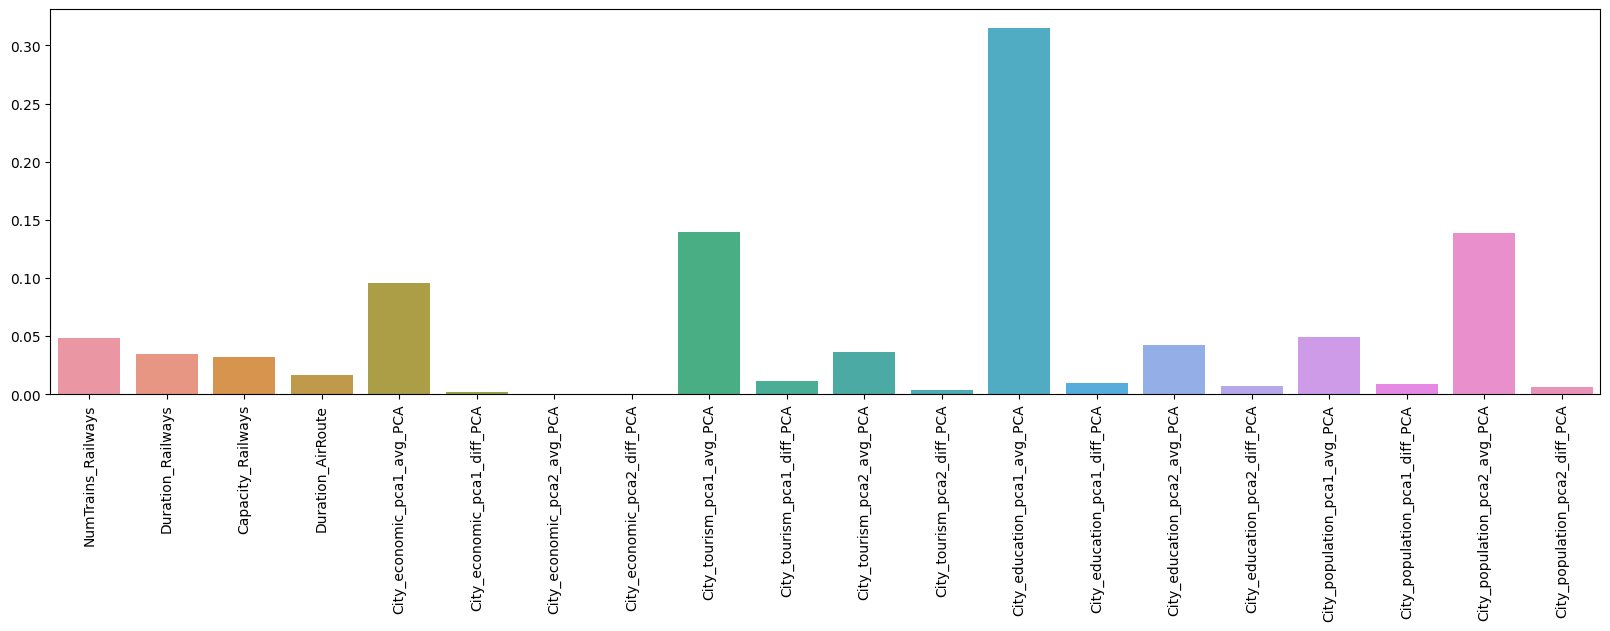

In [29]:
model_coefs = model.feature_importances_
print('Coefficients: ', model_coefs)
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
sns.barplot(x = X_features, y = np.abs(model_coefs), ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

# Preparing Selected Route Data

In [30]:
uniq_hubs = preprocessor.network_data[preprocessor.network_data['FromHub'] == 1]['From'].unique()
airport_df = preprocessor.all_airport_data.copy()
airport_df['IsHub'] = pd.Series(np.zeros(airport_df.shape[0]))
for airport in uniq_hubs:
    airport_idx = airport_df[airport_df['Name'] == airport].index[0]
    airport_df.loc[airport_idx, "IsHub"] = 1
airport_df = airport_df[['Name', 'City/Town', 'IsHub']]
print(uniq_hubs)

['BLR' 'HYD' 'BOM' 'CCU' 'DEL']


In [31]:
class ID_Generator:
    def __init__(self, max_range = 100):
        self.all_ids = []
        self.max_range = max_range
    
    def generate_id(self):
        new_id = 0
        while(True):
            new_id = np.random.randint(self.max_range)
            if(new_id not in self.all_ids):
                break
        self.all_ids.append(new_id)
        return new_id

class Airport:
    def __init__(self, airport_id):
        self.id = airport_id
        self.airport_info = {}
        self.to_list = []
        self.from_list = []
        self.to_airport_list = []
        self.from_airport_list = []
        
    def __str__(self):
        return self.airport_info['Name']
        
    def init_airport_info(self, airport_info):
        self.airport_info = airport_info
    
    def add_to_list(self, to_route):
        self.to_list.append(to_route)
        self.update_to_airports()
        
    def add_from_list(self, from_route):
        self.from_list.append(from_route)
        self.update_from_airports()
        
    def update_to_airports(self):
        self.to_airport_list = [x.to_airport for x in self.to_list]
    
    def update_from_airports(self):
        self.from_airport_list = [x.from_airport for x in self.from_list]

class Route:
    def __init__(self, route_id):
        self.id = route_id
        self.from_airport = None
        self.to_airport = None
        self.route_info = {}
    
    def __str__(self):
        return str(self.from_airport) + "-" + str(self.to_airport)
    
    def init_from_to(self, from_airport, to_airport):
        self.from_airport = from_airport
        self.to_airport = to_airport
        return self.update_from_to_list()
    
    def init_route_info(self, route_info):
        self.route_info = route_info
    
    def update_from_to_list(self):
        self.to_airport.add_from_list(self)
        self.from_airport.add_to_list(self)
        return self.from_airport, self.to_airport

def create_graph(route_df, airport_df, traffic_var, NODE_COLOR_MAP = None, NODE_SIZE_MAP = None, ROUTE_COLOR_MAP = None, ROUTE_WIDTH_MAP = None, use_node_color = True, use_node_size = True, use_route_color = True, use_route_width = True, disable_physics = False):
    
    graph = nx.from_pandas_edgelist(route_df, source = 'From', target = 'To', edge_attr = traffic_var, create_using = nx.DiGraph())

    if(use_node_color):
        node_colormap = airport_df.set_index('Name')[[NODE_COLOR_MAP[0]]].to_dict(orient = 'dict')[NODE_COLOR_MAP[0]]
        node_colormap = dict([(x[0], NODE_COLOR_MAP[1](x[1])) for x in node_colormap.items()])
        nx.set_node_attributes(graph, node_colormap, name = 'color')
    
    if(use_node_size):
        node_sizemap = airport_df.set_index('Name')[[NODE_SIZE_MAP[0]]].to_dict(orient = 'dict')[NODE_SIZE_MAP[0]]
        node_sizemap = dict([(x[0], NODE_SIZE_MAP[1](x[1])) for x in node_sizemap.items()])
        nx.set_node_attributes(graph, node_sizemap, name = 'size')

    if(use_route_color):
        route_colormap = route_df.set_index(['From', 'To'])[[ROUTE_COLOR_MAP[0]]].to_dict(orient = 'dict')[ROUTE_COLOR_MAP[0]]
        route_colormap = dict([((x[0][0], x[0][1]), ROUTE_COLOR_MAP[1](x[1])) for x in route_colormap.items()])
        nx.set_edge_attributes(graph, route_colormap, name = 'color')

    if(use_route_width):
        route_widthmap = route_df.set_index(['From', 'To'])[[ROUTE_WIDTH_MAP[0]]].to_dict(orient = 'dict')[ROUTE_WIDTH_MAP[0]]
        route_widthmap = dict([((x[0][0], x[0][1]), ROUTE_WIDTH_MAP[1](x[1])) for x in route_widthmap.items()])
        nx.set_edge_attributes(graph, route_widthmap, name = 'weight')

    # nx.draw_networkx(graph, node_color = colormap.values())
    net = Network(notebook = True, directed = True, filter_menu = True, select_menu = True, height="750px", width="100%", cdn_resources='remote')
    net.from_nx(graph)
    net.repulsion()
    if(disable_physics):
        net.toggle_physics(False)
    return net

def plot_network(
    raw_route_df, raw_airport_df, traffic_var = 'Dummy',
    USE_ONLY_SELECTIVE_CITIES = True, to_use_airports = [],
    NODE_COLOR_MAP = None, NODE_SIZE_MAP = None, ROUTE_COLOR_MAP = None, ROUTE_WIDTH_MAP = None,
    use_node_color = True, use_node_size = True, use_route_color = True, use_route_width = True
):
    route_df = raw_route_df.copy()
    route_attr_cols = [x for x in route_df.columns if x not in ['From', 'To']]
    airport_df = raw_airport_df.copy()
    airport_attr_cols = [x for x in airport_df.columns]

    if(USE_ONLY_SELECTIVE_CITIES):
        # Filterer
        exclude_idx = []
        for idx, row in route_df.iterrows():
            if((row['From'] not in to_use_airports) or (row['To'] not in to_use_airports)):
                exclude_idx.append(idx)
        route_df = route_df.drop(exclude_idx, axis = 0).reset_index(drop = True)

        exclude_idx = []
        for idx, row in airport_df.iterrows():
            if(row['Name'] not in to_use_airports):
                exclude_idx.append(idx)
        airport_df = airport_df.drop(exclude_idx, axis = 0).reset_index(drop = True)
        disable_physics = False
    else:
        disable_physics = True
    
    uniq_airports = [*airport_df['Name'].unique()]

    airport_id_gen = ID_Generator(100)
    route_id_gen = ID_Generator(1000)

    AIRPORTS = {}
    ROUTES = {}

    for idx, row in airport_df.iterrows():
        airport_obj = Airport(airport_id_gen.generate_id())
        airport_attr = dict([(x, row[x]) for x in airport_attr_cols])
        airport_obj.init_airport_info(airport_attr)
        AIRPORTS[row['Name']] = airport_obj

    for idx, row in route_df.iterrows():
        route_obj = Route(route_id_gen.generate_id())
        AIRPORTS[row['From']], AIRPORTS[row['To']] = route_obj.init_from_to(AIRPORTS[row['From']], AIRPORTS[row['To']])
        route_attr = dict([(x, row[x]) for x in route_attr_cols])
        route_obj.init_route_info(route_attr)
        ROUTES[f"{row['From']}-{row['To']}"] = route_obj
    
    net = create_graph(
        route_df, airport_df, traffic_var,
        NODE_COLOR_MAP = NODE_COLOR_MAP, use_node_color = use_node_color,
        NODE_SIZE_MAP = NODE_SIZE_MAP, use_node_size = use_node_size,
        ROUTE_COLOR_MAP = ROUTE_COLOR_MAP, use_route_color = use_route_color,
        ROUTE_WIDTH_MAP = ROUTE_WIDTH_MAP, use_route_width = use_route_width,
        disable_physics = disable_physics
    )
    return net, AIRPORTS, ROUTES

In [32]:
# Input variables
def node_attr_to_color_map(attr):
    if(attr == 1):
        return 'green'
    else:
        return 'red'

def node_attr_to_size_map(attr):
    return attr/5

def route_attr_to_color_map(attr):
    if(attr == 'Narrow Body'):
        return 'blue'
    elif(attr == 'Turbo-prop'):
        return 'red'
    elif(attr == 'Regional Jet'):
        return 'green'
    else:
        return 'black'
    
def route_attr_to_width_map(attr):
    return attr / 300

NODE_COLOR_MAP = ['IsHub', node_attr_to_color_map]
NODE_SIZE_MAP = []
ROUTE_COLOR_MAP = []
ROUTE_WIDTH_MAP = []

use_node_color = (len(NODE_COLOR_MAP) != 0)
use_node_size = (len(NODE_SIZE_MAP) != 0)
use_route_color = (len(ROUTE_COLOR_MAP) != 0)
use_route_width = (len(ROUTE_WIDTH_MAP) != 0)

In [33]:
net, AIRPORTS, ROUTES = plot_network(
    preprocessor.network_data.assign(Dummy = np.ones(preprocessor.network_data.shape[0]) * -1),
    airport_df,
    traffic_var = 'Dummy',
    USE_ONLY_SELECTIVE_CITIES = True, to_use_airports = tier_1_2_cities_airports,
    NODE_COLOR_MAP = NODE_COLOR_MAP, NODE_SIZE_MAP = NODE_SIZE_MAP, ROUTE_COLOR_MAP = ROUTE_COLOR_MAP, ROUTE_WIDTH_MAP = ROUTE_WIDTH_MAP,
    use_node_color = use_node_color, use_node_size = use_node_size, use_route_color = use_route_color, use_route_width = use_route_width
)
net.show('graph_network_demo_sample.html')

In [46]:
def get_route_demand_forecasts(SELECTED_CITY, SELECTED_HUB_AIRPORT):
    selected_hub_city = preprocessor.city_mapping[preprocessor.city_mapping['AirRouteData_AirportCode'] == SELECTED_HUB_AIRPORT].iloc[0]['City']
    connecting_airports = []
    for airport in AIRPORTS[SELECTED_HUB_AIRPORT].to_airport_list:
        if(airport not in connecting_airports):
            connecting_airports.append(airport)
    for airport in AIRPORTS[SELECTED_HUB_AIRPORT].from_airport_list:
        if(airport not in connecting_airports):
            connecting_airports.append(airport)
    
    expected_route_traffic_df = []
    for year in np.arange(PRESENT_YEAR, FORECAST_YEAR + 1):
        expected_route_traffic_df.append([SELECTED_CITY, selected_hub_city, year, ''])
        airport_to_city_mapping = dict(zip(preprocessor.city_mapping['AirRouteData_AirportCode'].values, preprocessor.city_mapping['City'].values))
        for airport in connecting_airports:
            expected_route_traffic_df.append([SELECTED_CITY, airport_to_city_mapping[airport.airport_info['Name']], year, selected_hub_city])
        expected_route_traffic_df.append([selected_hub_city, SELECTED_CITY, year, ''])
        airport_to_city_mapping = dict(zip(preprocessor.city_mapping['AirRouteData_AirportCode'].values, preprocessor.city_mapping['City'].values))
        for airport in connecting_airports:
            expected_route_traffic_df.append([airport_to_city_mapping[airport.airport_info['Name']], SELECTED_CITY, year, selected_hub_city])
    expected_route_traffic_df = pd.DataFrame(expected_route_traffic_df, columns = ['From', 'To', 'Year', 'Connecting'])
    
    expected_route_traffic_df = get_railways_info_features(expected_route_traffic_df)
    expected_route_traffic_df = get_route_timing_features(expected_route_traffic_df)
    expected_route_traffic_df = get_pca_vals_features(expected_route_traffic_df)
    duration_in = expected_route_traffic_df[(expected_route_traffic_df['From'] == selected_hub_city) & (expected_route_traffic_df['To'] == SELECTED_CITY)].iloc[0]['Duration_AirRoute']
    duration_out = expected_route_traffic_df[(expected_route_traffic_df['To'] == selected_hub_city) & (expected_route_traffic_df['From'] == SELECTED_CITY)].iloc[0]['Duration_AirRoute']
    
    for col_idx, col in enumerate(expected_route_traffic_df.columns):
        if(col in X_features):
            col_mean = np.nanmean(expected_route_traffic_df[col].values)
            expected_route_traffic_df[col] = expected_route_traffic_df[col].fillna(col_mean)
            col_mean = cols_standardization_vals[col]['mean']
            col_std = cols_standardization_vals[col]['std']
            expected_route_traffic_df[col] = (expected_route_traffic_df[col] - col_mean) / (col_std + 1e-20)
    
    data_X = expected_route_traffic_df[X_features]
    target_mean = cols_standardization_vals[y_features[0]]['mean']
    target_std = cols_standardization_vals[y_features[0]]['std']
    pred = model.predict(data_X) * target_std + (target_mean)
    expected_route_traffic_df['ForecastedDemand'] = pd.Series(pred)
    
    # Domestic Passenger Traffic would include local + connecting demand, hence excluding adding connecting demand
    CONNECTING_DEMAND_FACTOR = 0
    def adjust_connecting_demand(row):
        if(row['Connecting'] == ''):
            return row['ForecastedDemand']
        else:
            return row['ForecastedDemand'] * CONNECTING_DEMAND_FACTOR
    expected_route_traffic_df['AdjustedForecastedDemand'] = expected_route_traffic_df.apply(adjust_connecting_demand, axis = 1)
    
    # Domestic Passenger Traffic would include local + connecting demand, hence excluding adding connecting demand
    CONNECTING_DEMAND_FACTOR = 0
    def adjust_connecting_demand(row):
        if(row['Connecting'] == ''):
            return row['ForecastedDemand']
        else:
            return row['ForecastedDemand'] * CONNECTING_DEMAND_FACTOR
    expected_route_traffic_df['AdjustedForecastedDemand'] = expected_route_traffic_df.apply(adjust_connecting_demand, axis = 1)
    
    in_total_traffic = expected_route_traffic_df[expected_route_traffic_df['To'] == SELECTED_CITY]
    in_total_traffic = in_total_traffic.groupby('Year')['AdjustedForecastedDemand'].aggregate('sum').reset_index(drop = False)
    out_total_traffic = expected_route_traffic_df[expected_route_traffic_df['From'] == SELECTED_CITY]
    out_total_traffic = out_total_traffic.groupby('Year')['AdjustedForecastedDemand'].aggregate('sum').reset_index(drop = False)
    in_out_total_traffic = pd.merge(in_total_traffic, out_total_traffic, on = 'Year', suffixes = ('_InTraffic', '_OutTraffic'))
    
    actual_present_out_traffic = valid_route_traffic_df[(valid_route_traffic_df['From'] == SELECTED_CITY) & (valid_route_traffic_df['To'] == selected_hub_city)]
    if(actual_present_out_traffic.shape[0] > 0):
        assert(actual_present_out_traffic.shape[0] == 1)
        actual_present_out_traffic = actual_present_out_traffic.iloc[0]['Passengers_Target'] * target_std + target_mean
        out_traffic_adjustment = actual_present_out_traffic - in_out_total_traffic.iloc[0]['AdjustedForecastedDemand_OutTraffic']
        in_out_total_traffic['AdjustedForecastedDemand_OutTraffic'] = in_out_total_traffic['AdjustedForecastedDemand_OutTraffic'] + out_traffic_adjustment
    actual_present_in_traffic = valid_route_traffic_df[(valid_route_traffic_df['To'] == SELECTED_CITY) & (valid_route_traffic_df['From'] == selected_hub_city)]
    if(actual_present_in_traffic.shape[0] > 0):
        actual_present_in_traffic = actual_present_in_traffic.iloc[0]['Passengers_Target'] * target_std + target_mean
        in_traffic_adjustment = actual_present_in_traffic - in_out_total_traffic.iloc[0]['AdjustedForecastedDemand_InTraffic']
        in_out_total_traffic['AdjustedForecastedDemand_InTraffic'] = in_out_total_traffic['AdjustedForecastedDemand_InTraffic'] + in_traffic_adjustment
    
    in_out_total_traffic.to_csv(f"./Analysis_Outputs/Forecasted_Route_Demand/City{SELECTED_CITY}_Hub{SELECTED_HUB_AIRPORT}.csv", index = None)
    return in_out_total_traffic, (duration_in, duration_out)

In [47]:
airport_to_city_mapping = dict(zip(preprocessor.city_mapping['AirRouteData_AirportCode'].values, preprocessor.city_mapping['City'].values))
all_airports_in_network = [AIRPORTS[x].airport_info['Name'] for x in AIRPORTS]
print(all_airports_in_network)

most_growth_cities = pd.read_csv('./Analysis_Outputs/most_growth_cities.csv')
new_growing_cities = [x for x in most_growth_cities['City'].values if x not in all_airports_in_network]
route_info_df = []
assert(len(new_growing_cities) > 0)
if(len(new_growing_cities) >= 5):
    new_growing_cities = new_growing_cities[:5]
for city in new_growing_cities:
    for hub in uniq_hubs:
        SELECTED_CITY = city
        SELECTED_HUB_AIRPORT = hub
        print(f"City to be added: {SELECTED_CITY}, connected to hub {SELECTED_HUB_AIRPORT}")
        route_forecasted_demands, durations = get_route_demand_forecasts(SELECTED_CITY, SELECTED_HUB_AIRPORT)
        route_info_df.append([SELECTED_CITY, SELECTED_HUB_AIRPORT, durations[0], durations[1]])
route_info_df = pd.DataFrame(route_info_df, columns = ['City', 'Hub', 'IncomingFlightDuration', 'OutgoingFlightDuration'])
route_info_df.to_csv('./Analysis_Outputs/most_growth_routes.csv', index = None)

['AMD', 'ATQ', 'DED', 'DEL', 'JAI', 'LKO', 'PAT', 'CCU', 'BHO', 'BBI', 'RPR', 'HYD', 'MAA', 'BLR', 'PNQ', 'BOM', 'VTZ', 'TRV', 'GAU']
City to be added: Bhopal, connected to hub BLR


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


City to be added: Bhopal, connected to hub HYD
City to be added: Bhopal, connected to hub BOM


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


City to be added: Bhopal, connected to hub CCU
City to be added: Bhopal, connected to hub DEL


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


City to be added: Pune, connected to hub BLR


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


City to be added: Pune, connected to hub HYD
City to be added: Pune, connected to hub BOM


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


City to be added: Pune, connected to hub CCU
City to be added: Pune, connected to hub DEL


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


City to be added: Thiruvananthapuram, connected to hub BLR


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


City to be added: Thiruvananthapuram, connected to hub HYD
City to be added: Thiruvananthapuram, connected to hub BOM


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


City to be added: Thiruvananthapuram, connected to hub CCU
City to be added: Thiruvananthapuram, connected to hub DEL


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


City to be added: Visakhapatnam, connected to hub BLR


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


City to be added: Visakhapatnam, connected to hub HYD
City to be added: Visakhapatnam, connected to hub BOM


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


City to be added: Visakhapatnam, connected to hub CCU
City to be added: Visakhapatnam, connected to hub DEL


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


City to be added: Lucknow, connected to hub BLR


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


City to be added: Lucknow, connected to hub HYD
City to be added: Lucknow, connected to hub BOM


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


City to be added: Lucknow, connected to hub CCU
City to be added: Lucknow, connected to hub DEL


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
